<a href="https://colab.research.google.com/github/Beast-Leon/Voice-Analytics/blob/main/speech_text_pipeline_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Locate to my google drive
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("drive/My Drive/Colab Notebooks/Income")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# install all required packages
!pip install malaya_speech
!pip install textgrid
!pip install Levenshtein

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# import all required packages
import malaya_speech
import numpy as np
from malaya_speech import Pipeline
import re
import textgrid
import unicodedata
import re
import itertools
from tqdm import tqdm

/usr/local/lib/python3.7/dist-packages/malaya_boilerplate/frozen_graph.py:29: UserWarning: Cannot import beam_search_ops from Tensorflow Addons, `deep_model` for stemmer will not available to use, make sure Tensorflow Addons version >= 0.12.0
  'Cannot import beam_search_ops from Tensorflow Addons, `deep_model` for stemmer will not available to use, make sure Tensorflow Addons version >= 0.12.0'


In [4]:
# Set a sample audio path
AUDIO_PATH = 'SESSION0'
AUDIO_PATH2 = 'long_audios'
AUDIO_PATH3 = 'sample_audios'
# Set the default sample rate to be 16000
SR = 16000
# Set the average piece for an audio to be 10.
NUM_PARTS = 10

# Base Pipeline Overview:
1. Load model
2. Load audio files (individual or batch)
3. Perform speech-to-text conversion and output script files
5. Perform text processing on the scripts

### Step 1: Load model

In [5]:
# For singlish speech-to-text conversion, 
# models are: small-conformer-singlish, conformer-singlish
# and large-conformer-singlish.
model = malaya_speech.stt.deep_transducer(model = 'conformer-singlish')

### Step 2: Load audio files in batches or individually.

In [6]:
# Read into the AUDIO_PATH, and generate a list of all the audio names
def generate_audio_name_ls(audio_path):
    audio_name_ls = []
    if not os.path.exists(audio_path):
        return []
    for f in os.listdir(audio_path):
        audio_name_ls.append(f)
    return audio_name_ls

In [7]:
# Load audio from audio_name_ls generated using function of generate_audio_name_ls
# audio_name_ls contains a list of audio file names
def load_audio(audio_name_ls):
    audio_ls = []
    for i, name in enumerate(audio_name_ls):
        name_path = os.path.join(AUDIO_PATH2, name)
        cur_audio, _ = malaya_speech.load(name_path)
        audio_ls.append(cur_audio)
    
    return audio_ls


### Step 3: Perform speech-to-text conversion in batch or individually and output script files.

In [8]:
def speech_to_text(audio_ls):
    text_ls = model.greedy_decoder(audio_ls)
    return text_ls

### Set up the base pipeline

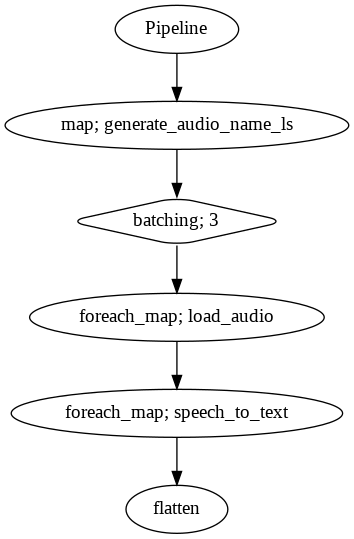

In [9]:
p = Pipeline()
p.map(generate_audio_name_ls).batching(3).foreach_map(load_audio).foreach_map(speech_to_text).flatten()
p.visualize()

### Try the base pipeline

In [10]:
"""
result_script = p(AUDIO_PATH1)
print(result_script.keys())
samp_text = result_script['flatten'][0]
samp_text
"""

"\nresult_script = p(AUDIO_PATH1)\nprint(result_script.keys())\nsamp_text = result_script['flatten'][0]\nsamp_text\n"

## More Advanced Pipeline

Caveats from the above base pipeline are shown as following:

1. Can't process long audio because of limited RAM.
2. Some audios contain noises

Addition in this Advanced Pipeline:

1. Split utterances using VAD. (slow)
We may just try by splitting piece by piece ourselves.

    We need to insert this step in the step 3 above
2. Do noice-reduction (optional).

In [11]:
# Try utterances split using VAD in malaya_speech
"""
vad = malaya_speech.vad.deep_model(model = 'vggvox-v2', quantized = True)
long_audio, sr = malaya_speech.load('long_audios/app_3001_4001_phnd_fin.wav')
vad_p = Pipeline()
pipeline = (
    vad_p.map(malaya_speech.utils.generator.frames, frame_duration_ms = 30)
    .batching(5)
    .foreach_map(vad.predict)
    .flatten()
)
vad_result = vad_p(long_audio)
vad_result.keys()

frames = vad_result['frames']
frames_vad = [
    (frame, vad_result['flatten'][no]) for no, frame in enumerate(frames)
]
"""

"\nvad = malaya_speech.vad.deep_model(model = 'vggvox-v2', quantized = True)\nlong_audio, sr = malaya_speech.load('long_audios/app_3001_4001_phnd_fin.wav')\nvad_p = Pipeline()\npipeline = (\n    vad_p.map(malaya_speech.utils.generator.frames, frame_duration_ms = 30)\n    .batching(5)\n    .foreach_map(vad.predict)\n    .flatten()\n)\nvad_result = vad_p(long_audio)\nvad_result.keys()\n\nframes = vad_result['frames']\nframes_vad = [\n    (frame, vad_result['flatten'][no]) for no, frame in enumerate(frames)\n]\n"

In [12]:
# Just try average split by simply dividing the audio by a constant
def speech_to_text_split(audio_ls):
    num_parts = NUM_PARTS
    text_ls = []
    for i, audio in enumerate(audio_ls):
        audio_len = len(audio)
        part_len = audio_len // num_parts
        if part_len * num_parts < audio_len:
            last_len = audio_len - part_len * num_parts
            num_parts += 1
        new_audio = []
        text = ""
        for i in range(0, num_parts):
            cur_start = i * part_len
            if i != num_parts - 1:
                cur_end = (i + 1) * part_len
            else:
                cur_end = audio_len
            cur_audio = audio[cur_start:cur_end]
            cur_result = model.greedy_decoder([cur_audio])[0]
            text += " "
            text += cur_result
        text_ls.append(text)
    return text_ls

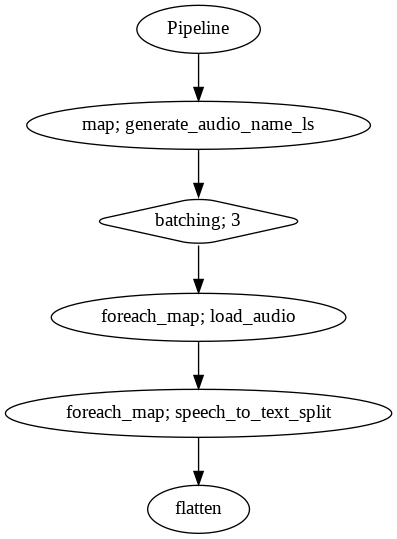

In [13]:
# update our pipeline.
p = Pipeline()
p.map(generate_audio_name_ls).batching(3).foreach_map(load_audio).foreach_map(speech_to_text_split).flatten()
p.visualize()

### Try the more advanced pipeline on a sample folder.

In [14]:
result_script2 = p(AUDIO_PATH3)

In [15]:
print(result_script2.keys())

dict_keys(['generate_audio_name_ls', 'batching', 'load_audio', 'speech_to_text_split', 'flatten'])


In [16]:
samp_text2 = result_script2['flatten'][0]

In [17]:
samp_text2

' hi is a bit soft ya so im using the seatly app to track my finances so like our keen like every expense so like you can actually like put in like whichever category it is so they will help you like tabulate like youll be on the charge chart ya so like every month i can see like how much i spend on food and transport so i guess like its quite helpful for me to be able to see how much as spend on food every month and whether i should like reduce the amount ya instead of like like you can on your note pet right but you have to like manually count and like tarik how much you spend in total is it ya so like i think this app really helps like you want if you are trying ya silly app ya you have to keep like every thing you spend on as in ya no that is troublesome but i ya i think it takes a while to like build the habit but ya sometimes i forgot to key in because i dont have to like maintenance count ya i hate counting like tabulating i will set a side like amount to pay off my loans i have

### Text Process on the resulting scripts.

In [18]:
vocabs = [" ", "a", "e", "n", "i", "t", "o", "u", "s", "k", "r",
          "l", "h", "d", "m", "g", "y", "b", "p", "w", "c", "f",
          "j", "v", "z", "0", "1", "x", "2", "q", "5", "3", "4",
          "6", "9", "8", "7"]

def preprocessing_text(text_ls): 
    new_text_ls = []
    for string in text_ls:
        string = unicodedata.normalize('NFC', string.lower()) # convert to lower case
        string = ''.join([c if c in vocabs else ' ' for c in string]) # only keep those characters in the vocabs list
        string = re.sub(r'[ ]+', ' ', string).strip() # remove trailing, leading, and any other extra spaces
        string = (
            ''.join(''.join(s)[:2] for _, s in itertools.groupby(string))
        ) # remove duplicated characters greater than 2
        new_text_ls.append(string)
    return new_text_ls

### Add Text Process to the pipeline

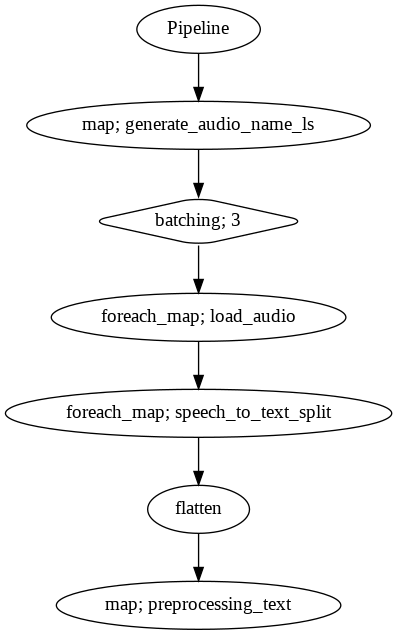

In [19]:
# update our pipeline.
p = Pipeline()
p.map(generate_audio_name_ls).batching(3).foreach_map(load_audio).foreach_map(speech_to_text_split).flatten().map(preprocessing_text)
p.visualize()

In [20]:
new_result = p(AUDIO_PATH2)